<a href="https://colab.research.google.com/github/arielisaac/AI_udacity_class/blob/main/project_1/LightweightFineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lightweight Fine-Tuning Project

TODO: In this cell, describe your choices for each of the following

* PEFT technique:           LoRA (Low-Rank Adaptation)
* Model:                    DistilBERT or GPT-2 or RoBERTa or LSTM (Long Short-Term Memory)
* Evaluation approach:      Classification Report
* Fine-tuning dataset:      IMDB Sentiment Analysis or SMS Spam dataset





## Loading and Evaluating a Foundation Model

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

In [90]:
!pip install transformers datasets peft accelerate evaluate optuna scikit-learn


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://nexus.corp.indeed.com/repository/pypi/simple


## A few Configurations

In [91]:
import torch
# Disable torch.compile for stability
torch._dynamo.config.disable = True

# This is to improve performance on M1 Macs
def get_best_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_best_device()

# ModernBERT blog: https://www.answer.ai/posts/2024-12-19-modernbert.html
# Philipp Schmid's blog on Fine-Tuning open LLMs: https://www.philschmid.de/fine-tune-llms-in-2025

# https://learn.udacity.com/nanodegrees/nd101-ent-ai-swe-indeed/parts/cd13303/lessons/786df5de-95ad-4e0d-be51-cc8a1c1e40fe/concepts/ed4cd691-b999-454e-b715-a603fb2aeeb5?lesson_tab=lesson
# https://huggingface.co/docs/peft/main/en/conceptual_guides/lora

# Necessary imports
from datasets import load_dataset
from peft import (AutoPeftModelForSequenceClassification,
                  LoraConfig,
                  get_peft_model,
                  TaskType)
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          DataCollatorWithPadding,
                          Trainer,
                          TrainingArguments)
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support
)

## Loading the Dataset

In [92]:

from datasets import load_dataset

# # Another dataset availabe: sms_spam
# sms_spam_dataset = load_dataset("sms_spam", split=["train"])[0]
# print(sms_spam_dataset)
# # Split the dataset into train and test sets (assuming `dataset` is a Hugging Face Dataset object)
# sms_spam_dataset_train_test_split = sms_spam_dataset.train_test_split(test_size=0.2, seed=42)
# test_dataset = sms_spam_dataset_train_test_split['test']
# print(sms_spam_dataset[:5])
# """
# Convert the dataset to a pandas DataFrame
# """
# import pandas as pd

# # Convert the entire dataset to a pandas DataFrame
# df = pd.DataFrame(sms_spam_dataset)
# # Display the first 10 rows
# print(df.head(10))

# # Or for more detailed information
# display(df.head(10))  # Works in Jupyter notebooks
# display(df.describe())  # Works in Jupyter notebooks

# for entry in dataset.select(range(3)):
#     sms = entry["sms"]
#     label = entry["label"]
#     print(f"label={label}, sms={sms}")

def load_and_analyze_dataset(dataset_name="imdb", splits=["train", "test"], sample_size=600, seed=42):
    """
    Load, sample, and analyze a dataset for classification tasks.

    Args:
        dataset_name (str): Name of the dataset to load from Hugging Face
        splits (list): List of splits to load (e.g., ["train", "test"])
        sample_size (int): Number of samples to select from each split (None for full dataset)
        seed (int): Random seed for shuffling

    Returns:
        dict: Dictionary containing the dataset splits
    """
    # Load the specified dataset splits
    dataset = {split: ds for split, ds in zip(splits, load_dataset(dataset_name, split=splits))}

    # Sample the dataset if sample_size is provided
    if sample_size is not None:
        for split in splits:
            dataset[split] = dataset[split].shuffle(seed=seed).select(range(sample_size))

    print(f"Loaded {dataset_name} dataset:")
    print(dataset)

    # Count the number of samples per class in each split
    analyze_class_distribution(dataset, splits=splits)

    return dataset

def analyze_class_distribution(dataset, splits=None):
    """
    Analyze and print the class distribution for each split in a dataset.

    Args:
        dataset (dict): Dictionary mapping split names to dataset objects
        splits (list): List of split names to analyze (if None, analyze all splits in dataset)
    """
    # If no specific splits are provided, analyze all splits in the dataset
    if splits is None:
        splits = dataset.keys()

    for split in splits:
        # Get all unique labels
        all_labels = set([item['label'] for item in dataset[split]])
        total = len(dataset[split])

        print(f"\n{split} split:")
        for label in sorted(all_labels):
            count = sum(1 for item in dataset[split] if item['label'] == label)
            print(f"  Label {label}: {count} ({count/total:.2%})")

    return dataset  # Return dataset to allow for function chaining

"""
Some conclusions:
with a 100 dataset also behave very well. A big improvement is seen for accuracy and recall.
"""


# Example usage:
splits = ["train", "test"]
dataset_size = 1000
# https://huggingface.co/datasets/stanfordnlp/imdb
dataset_used_to_fine_tuned = load_and_analyze_dataset("imdb", splits, sample_size= dataset_size)

# To load a different dataset, e.g., sms_spam:
#TODO: need to fix this one
# dataset_used_to_fine_tuned = load_and_analyze_dataset("sms_spam", splits=["train"], sample_size= dataset_size)


# https://huggingface.co/datasets/fancyzhx/ag_news this has 4 classes does not work
# dataset_used_to_fine_tuned = load_and_analyze_dataset("fancyzhx/ag_news",  sample_size= dataset_size)

# https://huggingface.co/datasets/stanfordnlp/sst2
# dataset_used_to_fine_tuned = load_and_analyze_dataset("stanfordnlp/sst2", splits=["train", "validation"],  sample_size= dataset_size)
#
# dataset_used_to_fine_tuned['test'] = dataset_used_to_fine_tuned['validation']
# validation_data = dataset_used_to_fine_tuned.pop("validation", None)
# analyze_class_distribution(dataset_used_to_fine_tuned, splits=splits)





Loaded imdb dataset:
{'train': Dataset({
    features: ['text', 'label'],
    num_rows: 1000
}), 'test': Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})}

train split:
  Label 0: 512 (51.20%)
  Label 1: 488 (48.80%)

test split:
  Label 0: 512 (51.20%)
  Label 1: 488 (48.80%)


## Loading the Model and Tokenize the dataset

In [93]:
#Models
# Very good documentation  https://huggingface.co/transformers/v4.2.2/training.html

from transformers import AutoModelForSequenceClassification

# Other model we can use is GPT-2
model_name = "gpt-2"
model_name = "distilbert-base-uncased"
def return_base_model(model_name ="distilbert-base-uncased"):
    model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},  # For converting predictions to strings
    label2id={"NEGATIVE": 0, "POSITIVE": 1},)
    model.to(device)
    return model

model = return_base_model()
print(model)

#Tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(rows):
    """Preprocess the dataset by returning tokenized examples."""
    # For SST2 dataset, use "sentence" instead of "text"
    if "sentence" in rows:
        return tokenizer(rows["sentence"], padding="max_length", truncation=True, return_tensors="pt")
    # For IMDB dataset, use "text"
    elif "text" in rows:
        return tokenizer(rows["text"], padding="max_length", truncation=True, return_tensors="pt")
    else:
        # If neither column exists, print available columns to help debug
        print("Available columns:", list(rows.keys()))
        raise KeyError("Could not find text column in dataset. Please specify the correct column name.")

# First, check what columns are available in your dataset
print("Available columns in dataset:", list(dataset_used_to_fine_tuned["train"].features.keys()))

tokenized_ds = {}
for split in splits:
    tokenized_ds[split] = dataset_used_to_fine_tuned[split].map(preprocess_function, batched=True)

tokenized_test = dataset_used_to_fine_tuned["test"].map(preprocess_function, batched=True)

# Check that we tokenized the examples properly only for the IMDB dataset.
#assert tokenized_ds["train"][0]["input_ids"][:5] == [101, 2045, 2003, 2053, 7189]

# Show the first example of the tokenized training set
print(tokenized_ds["train"][0]["input_ids"])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

[101, 2045, 2003, 2053, 7189, 2012, 2035, 2090, 3481, 3771, 1998, 6337, 2099, 2021, 1996, 2755, 2008, 2119, 2024, 2610, 2186, 2055, 6355, 6997, 1012, 6337, 2099, 3504, 15594, 2100, 1010, 3481, 3771, 3504, 4438, 1012, 6337, 2099, 14811, 2024, 3243, 3722, 1012, 3481, 3771, 1005, 1055, 5436, 2024, 2521, 2062, 8552, 1012, 1012, 1012, 3481, 3771, 3504, 2062, 2066, 3539, 8343, 1010, 2065, 2057, 2031, 2000, 3962, 12319, 1012, 1012, 1012, 1996, 2364, 2839, 2003, 5410, 1998, 6881, 2080, 1010, 2021, 2031, 1000, 17936, 6767, 7054, 3401, 1000, 1012, 2111, 2066, 2000, 12826, 1010, 2000, 3648, 1010, 2000, 16157, 1012, 2129, 2055, 2074, 9107, 1029, 6057, 2518, 2205, 1010, 2111, 3015, 3481, 3771, 3504, 2137, 2021, 1010, 2006, 1996, 2060, 2192, 1010, 9177, 2027, 9544, 2137, 2186, 1006, 999, 999, 999, 1007, 1012, 2672, 2009, 1005, 1055, 1996, 2653, 1010, 2030, 1996, 4382, 1010, 2021, 1045, 2228, 2023, 2186, 2003, 2062, 2394, 2084, 2137, 1012, 2011, 1996, 2126, 1010, 1996, 5889, 2024, 2428, 2204, 1998, 6

## Evaluating the pre trained (model not trained yet)

/var/folders/wk/pzcwnxxn535cgj1v_p1p_m140000gn/T/ipykernel_33953/1926597540.py:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.694320559501648, 'eval_model_preparation_time': 0.001, 'eval_accuracy': 0.491, 'eval_runtime': 11.1398, 'eval_samples_per_second': 89.768, 'eval_steps_per_second': 22.442}

Evaluating Base Model Set


Detected 2 classes in the data
Unique classes in predictions: [0 1]
Unique classes in ground truth: [0 1]
              precision    recall  f1-score   support

    Negative       0.50      0.75      0.60       512
    Positive       0.46      0.22      0.30       488

    accuracy                           0.49      1000
   macro avg       0.48      0.48      0.45      1000
weighted avg       0.48      0.49      0.45      1000



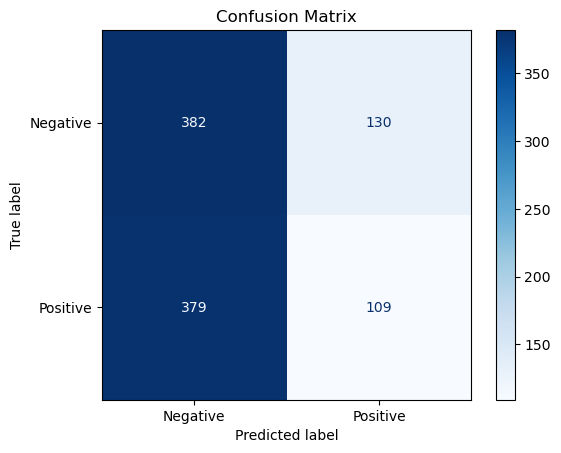

In [94]:
from sklearn.metrics import accuracy_score, f1_score,  precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

labels = ["Negative", "Positive"]
# 3.2 Evaluate base model before fine-tuning
def evaluate_model(model, dataset_split, split_name="Test"):
    print(f"\n{'='*40}")
    print(f"Evaluating {split_name} Set")
    print(f"{'='*40}")

    # Define evaluation arguments
    eval_args = TrainingArguments(
        output_dir="./pre_fine_tuning_results",
        report_to="none"  # Disable all logging integrations, including wandb
    )

    trainer = Trainer(
        args=eval_args,
        model=model,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        processing_class=tokenizer
    )

    outputs = trainer.predict(dataset_split)
    predictions = np.argmax(outputs.predictions, axis=1)
    labels = outputs.label_ids

    # Get unique classes from both true labels and predictions
    unique_classes = np.unique(np.concatenate([labels, predictions]))
    num_classes = len(unique_classes)
    print(f"Detected {num_classes} classes in the data")

    print("Unique classes in predictions:", np.unique(predictions))
    print("Unique classes in ground truth:", np.unique(labels))


    print(classification_report(labels, predictions, target_names=["Negative", "Positive"]))
    plot_confusion_matrix(labels, predictions)

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Negative", "Positive"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()



def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./result-distilbert-base",
        per_device_eval_batch_size=4,
        report_to="none"
    ),
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)
pre_finetune_eval = trainer.evaluate()
print(pre_finetune_eval)

# Pre-training evaluation on the tokenized dataset
evaluate_model(model, tokenized_ds["test"], "Base Model")

#
# """
# My own version
# """
# def evaluate_model_running_predictions(current_model, current_tokenized_test, split_name="Test"):
#     # Make predictions
#     predictions = []
#     true_labels = []
#
#     with torch.no_grad():
#         for i in range(len(current_tokenized_test)):
#             inputs = {
#                 "input_ids": torch.tensor(current_tokenized_test[i]["input_ids"]).unsqueeze(0).to(device),
#                 "attention_mask": torch.tensor(current_tokenized_test[i]["attention_mask"]).unsqueeze(0).to(device),
#             }
#             outputs = current_model(**inputs)
#             logits = outputs.logits
#             predicted_label = torch.argmax(logits, dim=1).item()
#             predictions.append(predicted_label)
#             true_labels.append(current_tokenized_test[i]["label"])
#
#     # Evaluate the predictions
#     accuracy = accuracy_score(true_labels, predictions)
#     f1_result = f1_score(true_labels, predictions)
#
#     print(f"\n{'='*40}")
#     print(f"Customized Evaluation {split_name} Set")
#     print(f"{'='*40}")
#     print(f"Accuracy: {accuracy}")
#     print(f"F1 result: {f1_result}")
#     print(f"Recall: {recall_score(true_labels, predictions)}")
#
#
#     # Calculate confusion matrix
#     cm = confusion_matrix(true_labels, predictions)
#
#     # Display the confusion matrix
#     labels = ["Negative", "Positive"]  # IMDB sentiment labels
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#     fig, ax = plt.subplots(figsize=(10, 10))
#     disp.plot(ax=ax)
#     plt.title("Confusion Matrix for IMDB Sentiment Classification")
#     plt.show()
#
# evaluate_model_running_predictions(model, tokenized_test, split_name="Test")

# Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.htweight Fine-Tuning

## Create the PEFT model

In [95]:
# Unfreeze all the model parameters.
# Hint: Check the documentation at https://huggingface.co/transformers/v4.2.2/training.html
model = return_base_model()

for param in model.parameters():
    param.requires_grad = True
# Helper function to find all linear layer names
def find_linear_layers(model):
    linear_layers = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            linear_layers.append(name)
    return linear_layers

# Get the actual linear layer names in your model
linear_layers = find_linear_layers(model)
print("Linear layers found:", linear_layers)
print(model)
from peft import LoraConfig
# https://huggingface.co/docs/peft/main/en/conceptual_guides/lora
# https://huggingface.co/docs/peft/main/en/task_guides/image_classification_lora
config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_CLS",
    # Use a more general approach to find linear layers
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj", "lin1", "lin2", "classifier"],
    modules_to_save=["classifier"],
    )

from peft import get_peft_model
lora_model = get_peft_model(model, config)

lora_model.print_trainable_parameters()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear layers found: ['distilbert.transformer.layer.0.attention.q_lin', 'distilbert.transformer.layer.0.attention.k_lin', 'distilbert.transformer.layer.0.attention.v_lin', 'distilbert.transformer.layer.0.attention.out_lin', 'distilbert.transformer.layer.0.ffn.lin1', 'distilbert.transformer.layer.0.ffn.lin2', 'distilbert.transformer.layer.1.attention.q_lin', 'distilbert.transformer.layer.1.attention.k_lin', 'distilbert.transformer.layer.1.attention.v_lin', 'distilbert.transformer.layer.1.attention.out_lin', 'distilbert.transformer.layer.1.ffn.lin1', 'distilbert.transformer.layer.1.ffn.lin2', 'distilbert.transformer.layer.2.attention.q_lin', 'distilbert.transformer.layer.2.attention.k_lin', 'distilbert.transformer.layer.2.attention.v_lin', 'distilbert.transformer.layer.2.attention.out_lin', 'distilbert.transformer.layer.2.ffn.lin1', 'distilbert.transformer.layer.2.ffn.lin2', 'distilbert.transformer.layer.3.attention.q_lin', 'distilbert.transformer.layer.3.attention.k_lin', 'distilbert.tr

## Train the PEFT model

In [96]:
from transformers import TrainingArguments, Trainer

batch_size = 1

import numpy as np
import evaluate

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

lora_model.gradient_checkpointing_enable()

trainer = Trainer(
    model=lora_model,
    args= TrainingArguments(
        f"{model_name}-finetuned-lora-101",
        remove_unused_columns=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=5e-3,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=batch_size,
        fp16=False,
        num_train_epochs=15,
        logging_steps=10,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy", # TODO: Check there could be a different metric
        push_to_hub=False,
        label_names=["labels"],
        report_to="none",
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],   # TODO: Check why do I have to pass the test set here
    #tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

train_results = trainer.train()


/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.573600,0.625956,0.710000
2,0.393700,0.639478,0.735000
3,0.311400,0.473297,0.804000
4,0.747200,0.369624,0.848000
5,0.434900,0.386606,0.846000
6,0.512000,0.481778,0.804000
7,0.415000,0.427313,0.836000
8,0.475600,0.432595,0.846000
9,0.407900,0.476644,0.843000
10,0.198400,0.569554,0.810000


/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/Users/arcartaya/miniconda3/lib/python3.12/site-packages/torch/utils/checkpoint.

## Save the PEFT model
###  ⚠️ IMPORTANT ⚠️

Due to workspace storage constraints, you should not store the model weights in the same directory but rather use `/tmp` to avoid workspace crashes which are irrecoverable.
Ensure you save it in /tmp always.

In [97]:
model_name_id = f"/tmp/{model_name}-finetuned-lora-101"
lora_model.save_pretrained(model_name_id)


## Performing Inference with a PEFT Model

### Load the saved PEFT model


TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

In [98]:
from peft import AutoPeftModelForSequenceClassification, PeftModelForSequenceClassification
# Load the base model first
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# Then, load the PEFT model using the base model
lora_model_load = PeftModelForSequenceClassification.from_pretrained(base_model, model_name_id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Evaluate the fine-tuned model

In [ ]:
trainer = Trainer(
    model=lora_model_load,
    args=TrainingArguments(
        output_dir="./result-distilbert-base-finetuned",
        per_device_eval_batch_size=4,
        report_to="none"
    ),
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)
post_finetune_eval = trainer.evaluate()
print(post_finetune_eval)

# Pre-training evaluation on the tokenized dataset
evaluate_model(lora_model_load, tokenized_ds["test"], "Base Model")

/var/folders/wk/pzcwnxxn535cgj1v_p1p_m140000gn/T/ipykernel_33953/5440130.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
